# Dataset 

https://www.kaggle.com/mariaren/covid19-healthy-diet-dataset

# Problem definition 

We chose a dataset combining different types of food, world population obesity and undernourished rate, and global covid cases count from around the world.

The idea is to understand how a healthy eating style could help combat the coronavirus, distinguishing the diet patterns from countries with lower COVID infection rate.

Our goal here is to provide diet recommendations based on our findings.

Each dataset provides different diet measure different categories of food, depending on what we want to focus on, so we have

- fat quantity,
- energy intake (kcal),
- food supply quantity (kg),
- protein for different categories of food

To which have been added:

- obesity rate
- undernourished rate
- the most up to date confirmed/deaths/recovered/active cases.

We are going to focus on the fat quantity dataset.

#### Lib and config

In [15]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

import plotly.express as px 

from sklearn.cluster import KMeans

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.tree import export_graphviz, plot_tree
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVC, SVC, SVR

#### Functions

In [2]:
def table_variable_attributes(df : pd.DataFrame) -> pd.DataFrame:  
    """Création table avec attributs des variables et % de valeurs manquantes"""  
    df_temp = (pd.DataFrame(  
        {  
            'variable' : df.isna().describe(include="all").columns,  
            'count' : df.isna().describe(include="all").loc['count'].astype(float),  
            'unique' : df.isna().describe(include="all").loc['unique'].astype(float),  
            'top' : df.isna().describe(include="all").loc['top'].astype(str),  
            'freq_top' : df.isna().describe(include="all").loc['freq'].astype(float)  
            # "unique" dit s'il y a des na ou pas dans la colonne (1=pas de NA, 2 = présence de Na)  
            # "count" nous donne le nb de lignes total  
            # "freq" nous donne le nb de lignes du "top"  
        }  
    )  
    .assign(percent_top=lambda df : df['freq_top']/df['count'])  
    .reset_index()  
    .assign(percent_na = lambda df : [df.loc[:,'percent_top'][row] if df['top'][row]=='True' else 1-df['percent_top'][row] for row in df.index] )  
    .drop(columns=['percent_top', 'index', 'unique', 'top', 'freq_top'])  
    .assign(percent_na=lambda df : round(df['percent_na']*100, 0),  
            count=lambda df : df['count'].astype(int))  
    .assign(type_variable = df.dtypes.astype(str).tolist())  
    )  
    return df_temp  

#### Data loading

Let's start by loading the data

In [3]:
fat_quantity = pd.read_csv("../data/Fat_Supply_Quantity_Data.csv")
fat_quantity

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,21.6397,6.2224,0.0,8.0353,0.6859,0.0327,0.4246,6.1244,...,17.0831,0.3593,4.5,29.8,0.125149,0.005058,0.098263,0.021827,38928000.0,%
1,Albania,0.0000,32.0002,3.4172,0.0,2.6734,1.6448,0.1445,0.6418,8.7428,...,9.2443,0.6503,22.3,6.2,1.733298,0.035800,0.874560,0.822939,2838000.0,%
2,Algeria,0.0000,14.4175,0.8972,0.0,4.2035,1.2171,0.2008,0.5772,3.8961,...,27.3606,0.5145,26.6,3.9,0.208754,0.005882,0.137268,0.065604,44357000.0,%
3,Angola,0.0000,15.3041,1.3130,0.0,6.5545,0.1539,1.4155,0.3488,11.0268,...,22.4638,0.1231,6.8,25,0.050049,0.001144,0.027440,0.021465,32522000.0,%
4,Antigua and Barbuda,0.0000,27.7033,4.6686,0.0,3.2153,0.3872,1.5263,1.2177,14.3202,...,14.4436,0.2469,19.1,NaN,0.151020,0.005102,0.140816,0.005102,98000.0,%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,Venezuela (Bolivarian Republic of),0.0000,16.3261,2.2673,0.0,2.5449,0.6555,0.5707,0.9640,7.0949,...,29.5211,0.1851,25.2,21.2,0.377466,0.003351,0.359703,0.014411,28645000.0,%
166,Vietnam,0.0000,33.2484,3.8238,0.0,3.7155,0.7839,1.1217,0.4079,26.4292,...,5.6211,0.6373,2.1,9.3,0.001457,0.000036,0.001295,0.000126,96209000.0,%
167,Yemen,0.0000,12.5401,2.0131,0.0,11.5271,0.5514,0.3847,0.2564,8.0010,...,23.6312,0.1667,14.1,38.9,0.006987,0.002032,0.004640,0.000315,29826000.0,%
168,Zambia,0.0783,9.6005,1.6113,0.0,14.3225,0.6266,1.0070,0.1343,4.9010,...,15.2848,0.1567,6.5,46.7,0.099663,0.001996,0.094696,0.002970,18384000.0,%


 ## Data Exploration and Processing

Now let's explore the dataset:
- check the head
- the columns
- the variable types

In [4]:
fat_quantity.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0,21.6397,6.2224,0.0,8.0353,0.6859,0.0327,0.4246,6.1244,...,17.0831,0.3593,4.5,29.8,0.125149,0.005058,0.098263,0.021827,38928000.0,%
1,Albania,0.0,32.0002,3.4172,0.0,2.6734,1.6448,0.1445,0.6418,8.7428,...,9.2443,0.6503,22.3,6.2,1.733298,0.035800,0.874560,0.822939,2838000.0,%
2,Algeria,0.0,14.4175,0.8972,0.0,4.2035,1.2171,0.2008,0.5772,3.8961,...,27.3606,0.5145,26.6,3.9,0.208754,0.005882,0.137268,0.065604,44357000.0,%
3,Angola,0.0,15.3041,1.3130,0.0,6.5545,0.1539,1.4155,0.3488,11.0268,...,22.4638,0.1231,6.8,25,0.050049,0.001144,0.027440,0.021465,32522000.0,%
4,Antigua and Barbuda,0.0,27.7033,4.6686,0.0,3.2153,0.3872,1.5263,1.2177,14.3202,...,14.4436,0.2469,19.1,NaN,0.151020,0.005102,0.140816,0.005102,98000.0,%


In [5]:
table_variable_attributes(fat_quantity)

,variable,count,percent_na,type_variable
0,Country,170,0.0,object
1,Alcoholic Beverages,170,0.0,float64
2,Animal Products,170,0.0,float64
3,Animal fats,170,0.0,float64
4,"Aquatic Products, Other",170,0.0,float64
5,Cereals - Excluding Beer,170,0.0,float64
6,Eggs,170,0.0,float64
7,"Fish, Seafood",170,0.0,float64
8,Fruits - Excluding Wine,170,0.0,float64
9,Meat,170,0.0,float64


Let's create a function to **check missing data** and unveil **the percentage of data missing** for each dataframe

Delete the countries for which values are missing.

In [6]:
fat_quantity_clean = fat_quantity.dropna()

Look at the different data types for each variable.

In [7]:
table_variable_attributes(fat_quantity_clean)

,variable,count,percent_na,type_variable
0,Country,154,0.0,object
1,Alcoholic Beverages,154,0.0,float64
2,Animal Products,154,0.0,float64
3,Animal fats,154,0.0,float64
4,"Aquatic Products, Other",154,0.0,float64
5,Cereals - Excluding Beer,154,0.0,float64
6,Eggs,154,0.0,float64
7,"Fish, Seafood",154,0.0,float64
8,Fruits - Excluding Wine,154,0.0,float64
9,Meat,154,0.0,float64


Explore the variables that are not of float type and see of you can convert them in to float type.

<font color="brown">

Country : c'est le label des individus/instances, on peut remplacer par des n° si on veut ou juste delete la colonne

Undernourished : les valeurs <2.5% sont notées avec le symbole, on peut l'enlever? Ou faire des classes avec un onehotencoder/getdummies ? 

Unit : on peut supprimer la colonne

</font>

In [8]:
fat_quantity_clean.Undernourished.unique()

array(['29.8', '6.2', '3.9', '25', '4.6', '4.3', '<2.5', '14.7', '7.5',
       '10.1', '17.1', '26.4', '3.6', '20', '12.6', '16.4', '9.9', '59.6',
       '37.5', '8.5', '4.8', '40.3', '19', '5.6', '18.9', '9.5', '7.9',
       '4.5', '9', '2.9', '20.6', '3.7', '10.5', '10.2', '5.5', '15.2',
       '16.5', '28', '8.1', '49.3', '12.9', '14.5', '8.3', '4.9', '29',
       '8', '12.2', '29.4', '2.8', '7.1', '11', '13.1', '37.2', '44.4',
       '17.5', '2.5', '10.3', '6.3', '10.4', '6.5', '13.4', '3.4', '27.9',
       '27.3', '8.7', '17', '3.2', '6.8', '20.3', '10', '10.7', '9.7',
       '13.3', '36.8', '5.7', '2.7', '7', '11.3', '25.6', '8.9', '20.1',
       '7.8', '24.9', '16.1', '41', '3.5', '2.6', '30.7', '7.2', '21.2',
       '9.3', '38.9', '46.7', '51.3'], dtype=object)

In [9]:
def creation_classes_var_undernourished(df:pd.DataFrame)->pd.DataFrame:
    df_temp=df.copy()
    df_temp = (df_temp
                      .replace(to_replace='<2.5', value='2.5')
                      .astype({'Undernourished': 'float'})
                      )
    conditions=[    df_temp['Undernourished']<=10,  #10 catégories de 0 à 60 0-10 10-20 20-30 30-40 
                    df_temp['Undernourished']<=20,  
                    df_temp['Undernourished']<=30,
                    df_temp['Undernourished']<=40,
                    df_temp['Undernourished']<=50,
                    df_temp['Undernourished']<=60
            ]  
    choices = ["0-10", "11-20", "21-30", "31-40", "41-50", "51-60"]  
    df_temp['Undernourished_cat']=np.select(conditions, choices, np.nan).astype(str)  
    df_temp = pd.get_dummies(df_temp, columns=['Undernourished_cat'], prefix='Undernourished', dtype=float).drop(columns=['Undernourished'])
    return df_temp


fat_quantity_clean = creation_classes_var_undernourished(fat_quantity_clean).drop(columns=['Unit (all except Population)'])
fat_quantity_clean



,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Deaths,Recovered,Active,Population,Undernourished_0-10,Undernourished_11-20,Undernourished_21-30,Undernourished_31-40,Undernourished_41-50,Undernourished_51-60
0,Afghanistan,0.0000,21.6397,6.2224,0.0,8.0353,0.6859,0.0327,0.4246,6.1244,...,0.005058,0.098263,0.021827,38928000.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Albania,0.0000,32.0002,3.4172,0.0,2.6734,1.6448,0.1445,0.6418,8.7428,...,0.035800,0.874560,0.822939,2838000.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Algeria,0.0000,14.4175,0.8972,0.0,4.2035,1.2171,0.2008,0.5772,3.8961,...,0.005882,0.137268,0.065604,44357000.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Angola,0.0000,15.3041,1.3130,0.0,6.5545,0.1539,1.4155,0.3488,11.0268,...,0.001144,0.027440,0.021465,32522000.0,0.0,0.0,1.0,0.0,0.0,0.0
5,Argentina,0.0000,30.3572,3.3076,0.0,1.3316,1.5706,0.1664,0.2091,19.2693,...,0.090444,2.953302,0.268993,45377000.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,Venezuela (Bolivarian Republic of),0.0000,16.3261,2.2673,0.0,2.5449,0.6555,0.5707,0.9640,7.0949,...,0.003351,0.359703,0.014411,28645000.0,0.0,0.0,1.0,0.0,0.0,0.0
166,Vietnam,0.0000,33.2484,3.8238,0.0,3.7155,0.7839,1.1217,0.4079,26.4292,...,0.000036,0.001295,0.000126,96209000.0,1.0,0.0,0.0,0.0,0.0,0.0
167,Yemen,0.0000,12.5401,2.0131,0.0,11.5271,0.5514,0.3847,0.2564,8.0010,...,0.002032,0.004640,0.000315,29826000.0,0.0,0.0,0.0,1.0,0.0,0.0
168,Zambia,0.0783,9.6005,1.6113,0.0,14.3225,0.6266,1.0070,0.1343,4.9010,...,0.001996,0.094696,0.002970,18384000.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
table_variable_attributes(fat_quantity_clean)

,variable,count,percent_na,type_variable
0,Country,154,0.0,object
1,Alcoholic Beverages,154,0.0,float64
2,Animal Products,154,0.0,float64
3,Animal fats,154,0.0,float64
4,"Aquatic Products, Other",154,0.0,float64
5,Cereals - Excluding Beer,154,0.0,float64
6,Eggs,154,0.0,float64
7,"Fish, Seafood",154,0.0,float64
8,Fruits - Excluding Wine,154,0.0,float64
9,Meat,154,0.0,float64


# Clustering

## Data preparation

Scale the dataset

In [11]:
scaler=StandardScaler()

fat_quantity_norm = scaler.fit_transform(fat_quantity_clean.drop(columns=["Country"]))

fat_quantity_norm

array([[-0.11401464,  0.15851008,  0.61692464, ..., -0.18318583,
        -0.18318583, -0.11470787],
       [-0.11401464,  1.45331082, -0.22062144, ..., -0.18318583,
        -0.18318583, -0.11470787],
       [-0.11401464, -0.74408245, -0.97301561, ..., -0.18318583,
        -0.18318583, -0.11470787],
       ...,
       [-0.11401464, -0.97871001, -0.63984234, ...,  5.45893763,
        -0.18318583, -0.11470787],
       [ 7.70185454, -1.34608574, -0.75980741, ..., -0.18318583,
         5.45893763, -0.11470787],
       [-0.11401464, -1.24871793, -0.35882909, ..., -0.18318583,
        -0.18318583,  8.71779789]])

## Plot some data

Now, we want to visualize some variables for each state. To do so, we use plotly express to have the possibility to hover on a scatter plot and see the statistics per country clearer as explained here.

https://plotly.com/python/hover-text-and-formatting/#:~:text=Basic%20Charts%20tutorials.-,Hover%20Labels,having%20a%20hover%20label%20appear.

Plot the "Obesity" vs "Deaths" statistics

In [12]:
fat_quantity_clean.columns

Index(['Country', 'Alcoholic Beverages', 'Animal Products', 'Animal fats',
       'Aquatic Products, Other', 'Cereals - Excluding Beer', 'Eggs',
       'Fish, Seafood', 'Fruits - Excluding Wine', 'Meat', 'Miscellaneous',
       'Milk - Excluding Butter', 'Offals', 'Oilcrops', 'Pulses', 'Spices',
       'Starchy Roots', 'Stimulants', 'Sugar Crops', 'Sugar & Sweeteners',
       'Treenuts', 'Vegetal Products', 'Vegetable Oils', 'Vegetables',
       'Obesity', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Population',
       'Undernourished_0-10', 'Undernourished_11-20', 'Undernourished_21-30',
       'Undernourished_31-40', 'Undernourished_41-50', 'Undernourished_51-60'],
      dtype='object')

In [72]:
px.scatter(fat_quantity_clean, 
           x='Obesity',
           y='Deaths', 
           width=600,
           height=500)



Plot the "Animal fats" vs "Deaths" statistics

In [17]:
fat_quantity_clean.columns

Index(['Country', 'Alcoholic Beverages', 'Animal Products', 'Animal fats',
       'Aquatic Products, Other', 'Cereals - Excluding Beer', 'Eggs',
       'Fish, Seafood', 'Fruits - Excluding Wine', 'Meat', 'Miscellaneous',
       'Milk - Excluding Butter', 'Offals', 'Oilcrops', 'Pulses', 'Spices',
       'Starchy Roots', 'Stimulants', 'Sugar Crops', 'Sugar & Sweeteners',
       'Treenuts', 'Vegetal Products', 'Vegetable Oils', 'Vegetables',
       'Obesity', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Population',
       'Undernourished_0-10', 'Undernourished_11-20', 'Undernourished_21-30',
       'Undernourished_31-40', 'Undernourished_41-50', 'Undernourished_51-60'],
      dtype='object')

In [75]:
px.scatter_matrix(
fat_quantity_clean,
dimensions=[
"Obesity",
"Animal fats",
"Alcoholic Beverages",
# "petal_width",
"Deaths",
],
# color="species",
width=600,
height=400
)

## K-means and Elbow method

We start with the K-Means model:
- use the scikit-learn method
- use the method you implemented.

Use a graphical tool, the elbow method, to estimate the optimal number of clusters k for a given task.
- Determine the optimal number of clusters for the previous 2 plots.

In [63]:
from sklearn.cluster import KMeans

number_cluster = 5

kmeans = KMeans(n_clusters=number_cluster, random_state=42, n_init=10)

kmeans.fit(fat_quantity_norm)



KMeans(n_clusters=5, n_init=10, random_state=42)

Plot the obtained clusters

In [65]:
kmeans.predict(fat_quantity_norm) #nouvelle colonne clusters

df = fat_quantity_clean.assign(predicted_cluster=kmeans.predict(fat_quantity_norm).astype(str) )
px.scatter(df, 
           x='Obesity',
           y='Deaths', 
           color="predicted_cluster",
           width=600, 
           height=500)

In [66]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pd.DataFrame({
    "PC1" : pca.fit_transform(fat_quantity_norm)[:, 0],
    "PC2" : pca.fit_transform(fat_quantity_norm)[:, 1],
    "predicted_cluster" : kmeans.predict(fat_quantity_norm).astype(str)})

px.scatter(df_pca, 
           x='PC1',
           y='PC2', 
           color="predicted_cluster",
           width=600,
           height=500)

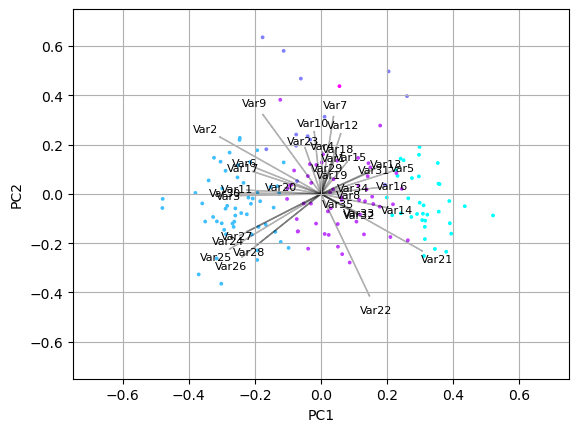

In [68]:
def myplot(score,coeff,labels=None, cluster_color ="grey"):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c= cluster_color, s=3, cmap='cool')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'black',alpha = 0.25)
        if labels is None:
            plt.text(x=coeff[i,0]* 1.15, y=coeff[i,1] * 1.15, s="Var"+str(i+1), color = 'black', ha = 'center', va = 'center', fontsize=8)
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center', fontsize=8)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
x_new = pca.fit_transform(fat_quantity_norm)
cluster = kmeans.predict(fat_quantity_norm).astype(int)
# cluster_color = cluster[cluster==0] = 
myplot(x_new[:,0:2], np.transpose(pca.components_[0:2, :]), cluster_color=cluster)
plt.xlim(-0.75,0.75)
plt.ylim(-0.75,0.75)
plt.show()

#
#fat_quantity_clean.drop(columns=["Country"]).columns.values

In [70]:
pd.DataFrame({
    "Variables" : fat_quantity_clean.drop(columns=["Country"]).columns.values})


,Variables
0,Alcoholic Beverages
1,Animal Products
2,Animal fats
3,"Aquatic Products, Other"
4,Cereals - Excluding Beer
5,Eggs
6,"Fish, Seafood"
7,Fruits - Excluding Wine
8,Meat
9,Miscellaneous


With distorsion :
1 : 5.502893746441536
2 : 4.929255640350798
3 : 4.738582760098148
4 : 4.641862161263532
5 : 4.5948189775286385
6 : 4.425710439071513
7 : 4.299012931960566
8 : 4.182874883970028
9 : 4.151429566755363


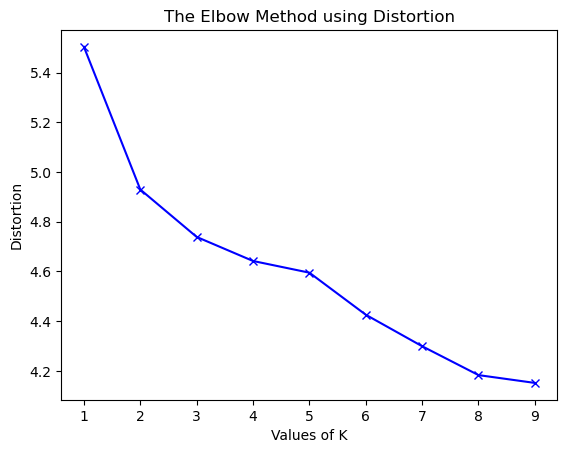

With inertia : 
1 : 5389.999999999999
2 : 4453.507081377336
3 : 4183.628912463937
4 : 3993.418400518942
5 : 3810.8599496454112
6 : 3668.023273796847
7 : 3481.2992616969227
8 : 3243.119337026822
9 : 3170.1706996453604


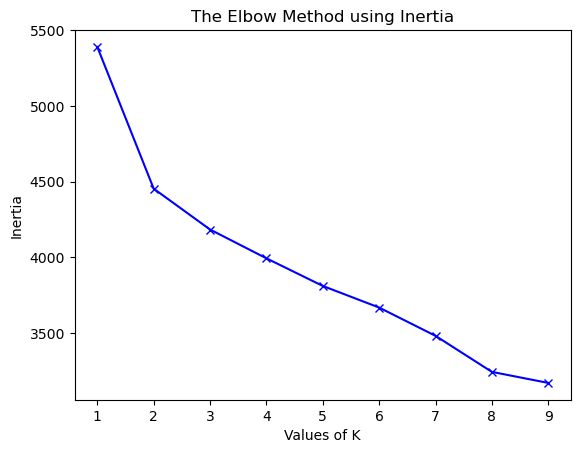

In [59]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

X=fat_quantity_norm

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_


print("With distorsion :")
for key, val in mapping1.items():
    print(f'{key} : {val}')



plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()



print('With inertia : ')
for key, val in mapping2.items():
    print(f'{key} : {val}')




plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


## Other clustering methods

We are going to explore other clustering methods, such as Mean-Shift.

You can read more about it in the next ressource:
https://scikit-learn.org/stable/modules/clustering.html


Apply the method to our datasets made of 2 variables ("Obesity" vs "Deaths")

In [84]:
# Mean-Shift
from sklearn.cluster import MeanShift, estimate_bandwidth


X  = fat_quantity_clean.loc[:, ['Obesity', 'Deaths']]
X_norm = scaler.fit_transform(X)

meanshift = MeanShift(bandwidth=1.001)
meanshift.fit_predict(X_norm)

df = pd.DataFrame(
    {
        'axe_x' : X['Obesity'],
        'axe_y' : X['Deaths'],
        'cluster' : meanshift.fit_predict(X_norm).astype(str)
    }
)

px.scatter(df, 
           x='axe_x',
           y='axe_y', 
           color="cluster",
           width=600,
           height=500)

In [82]:
meanshift.fit_predict(X_norm)

array([0, 1, 1, 0, 2, 2, 1, 2, 1, 0, 1, 1, 4, 2, 0, 2, 2, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 1, 0, 2, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 0,
       0, 1, 1, 2, 0, 0, 2, 1, 0, 1, 1, 0, 0, 1, 1, 1, 2, 1, 0, 0, 2, 1,
       2, 1, 2, 1, 0, 1, 1, 0, 0, 3, 0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 0, 0,
       0, 1, 0, 0, 2, 1, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 2, 1, 1, 0, 2, 1,
       4, 0, 2, 2, 2, 1, 0, 1, 3, 0, 1, 0, 1, 0, 1, 2, 1, 1, 2, 0, 0, 1,
       2, 2, 0, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 2, 1, 0, 1, 1, 0, 0, 0, 0])

In [83]:
estimate_bandwidth(X_norm)

1.001096409626414

Plot the obtained clusters

Check out other algorithms such as DBSAN or OPTICS, why are these algorithms very interesting and in what cases? 

In [85]:
from sklearn.cluster import DBSCAN



X  = fat_quantity_clean.loc[:, ['Obesity', 'Deaths']]
X_norm = scaler.fit_transform(X)

dbscan = DBSCAN()
dbscan.fit_predict(X_norm)

df = pd.DataFrame(
    {
        'axe_x' : X['Obesity'],
        'axe_y' : X['Deaths'],
        'cluster' : dbscan.fit_predict(X_norm).astype(str)
    }
)

px.scatter(df, 
           x='axe_x',
           y='axe_y', 
           color="cluster",
           width=600,
           height=500)


In [86]:
from sklearn.cluster import OPTICS

X  = fat_quantity_clean.loc[:, ['Obesity', 'Deaths']]
X_norm = scaler.fit_transform(X)

optics = OPTICS()
optics.fit_predict(X_norm)

df = pd.DataFrame(
    {
        'axe_x' : X['Obesity'],
        'axe_y' : X['Deaths'],
        'cluster' : optics.fit_predict(X_norm).astype(str)
    }
)

px.scatter(df, 
           x='axe_x',
           y='axe_y', 
           color="cluster",
           width=600,
           height=500)

### Comparaison des algorithmes de clustering

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png'/>


# Regression and prediction

Given this dataset and the emphasis we have already laid on deaths through clustering, it would be interesting to study this dataset for a classification purpose and see how accurately we can predict the mortality rate in fonction of the given features.

<font color = 'brown'>

on compare RMSE avec la STD de la target dans le dataset (afficher une ligne)

quand on regarde l'accuracy pour des données catégorielles, elle est scalée en % donc on s'en fou de la ligne

</font>

## Creating train and test sets 

Let's separate the data into a training and testing sets using random selection.

In [90]:
from sklearn.model_selection import train_test_split
#mortality rate = target 

X = fat_quantity_clean.drop(columns=["Country", "Deaths"])
y = fat_quantity_clean.loc[:,"Deaths"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [92]:
y_train

103    0.018522
146    0.071276
18     0.103353
159    0.096039
12     0.002439
         ...   
77     0.031904
116    0.031233
16     0.000360
100    0.089441
112    0.000339
Name: Deaths, Length: 103, dtype: float64

Now drop the labels from the training set and create a new variable for the labels.

In [94]:
X_train

,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Miscellaneous,...,Confirmed,Recovered,Active,Population,Undernourished_0-10,Undernourished_11-20,Undernourished_21-30,Undernourished_31-40,Undernourished_41-50,Undernourished_51-60
103,0.0,15.4227,3.5807,0.0,7.1539,1.1517,1.2329,0.7014,6.9989,0.0074,...,1.114892,0.998734,0.097636,35952000.0,1.0,0.0,0.0,0.0,0.0,0.0
146,0.0,28.1054,6.2293,0.0,1.1241,0.9300,0.4048,0.3379,12.0906,0.0000,...,4.453984,3.570767,0.811941,8634000.0,1.0,0.0,0.0,0.0,0.0,0.0
18,0.0,24.6478,2.4453,0.0,3.6588,0.8354,0.3049,0.5976,9.6957,0.0915,...,3.092380,2.026394,0.962633,3281000.0,1.0,0.0,0.0,0.0,0.0,0.0
159,0.0,25.8633,4.2615,0.0,1.4678,1.0778,0.5176,0.4219,12.5789,0.0780,...,2.791642,0.006027,2.689576,67160000.0,1.0,0.0,0.0,0.0,0.0,0.0
12,0.0,25.8451,3.9733,0.0,2.1187,1.2130,1.8060,0.4636,13.1382,0.3235,...,0.103136,0.094774,0.005923,287000.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.0,12.2622,1.8696,0.0,3.7391,0.5224,0.3189,0.1980,5.8122,0.0385,...,2.457880,2.084971,0.341006,10679000.0,0.0,1.0,0.0,0.0,0.0,0.0
116,0.0,23.6146,2.3712,0.0,3.7744,1.4422,0.9290,0.7926,9.0171,0.0325,...,2.684150,2.509803,0.143115,4713000.0,1.0,0.0,0.0,0.0,0.0,0.0
16,0.0,6.1742,0.4816,0.0,4.6952,0.2064,0.8599,0.1978,3.2849,0.0258,...,0.025309,0.024343,0.000606,12209000.0,0.0,1.0,0.0,0.0,0.0,0.0
100,0.0,23.7741,3.2525,0.0,6.4604,2.2807,0.4661,0.5305,13.2133,0.0050,...,0.982827,0.725988,0.167399,127792000.0,1.0,0.0,0.0,0.0,0.0,0.0


Scale the datasets.

In [168]:
scaler=StandardScaler()

X_train_norm = scaler.fit_transform(X_train)

X_test_norm = scaler.transform(X_test)

y_train = (y_train)/y_train.std()
y_test = y_test/y_train.std()

## Random Forest

Let's try a random forest model on the prepared fat_quantity training set.

In [100]:
from sklearn.ensemble import RandomForestRegressor

max_depth=5
n_estimators = 100

forest_reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
forest_reg.fit(X_train_norm, y_train)


RandomForestRegressor(max_depth=5, random_state=42)

Now we predict.

In [101]:
forest_reg.predict(X_test_norm)

px.scatter(
    x= forest_reg.predict(X_test_norm), #predicted
    y= y_test ,#reelles
    width=600,
    height=500
)

Let's perform a 10 fold cross validation.
And display the resulting scores:

In [110]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(forest_reg, X_train_norm, y_train, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True)

print("Forest regression root mean sq error (val set): " , abs(cv_results['test_score']).mean())
print("Forest regression root mean sq error (train set): ", abs(cv_results['train_score']).mean())

Forest regression root mean sq error (val set):  0.017684369589003303
Forest regression root mean sq error (train set):  0.007462723338911445


## Learning Curves analysis 

Use the function seen in **Module 1 to plot learning curves with cross validation.** 

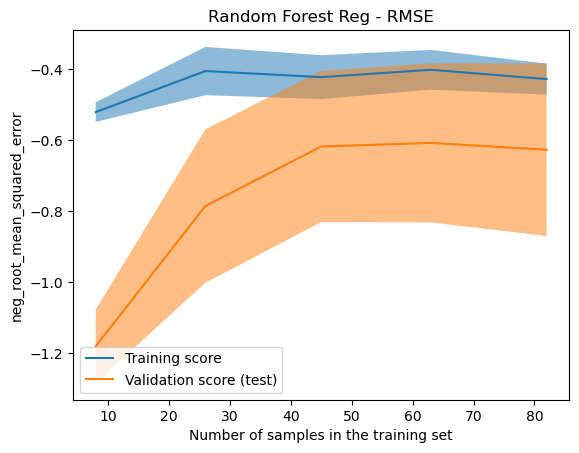

In [170]:
from sklearn.model_selection import learning_curve, LearningCurveDisplay

def plot_learning_curve(estimator, title , X, y, scoring = None, axes=None, ylim=None, cv=5,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
# create your method to plot your learning curves using the sklearn method learning_curve()
    scaler=StandardScaler()
    X_norm = scaler.fit_transform(X)
    estimator.fit(X_norm, y)
    train_size_abs, train_scores, test_scores = learning_curve(estimator, X_train, y_train, train_sizes=train_sizes, 
                                                            cv=cv, scoring=scoring, n_jobs=n_jobs)
    LearningCurveDisplay(train_sizes=train_size_abs, train_scores = (train_scores), test_scores=(test_scores), score_name=f"{scoring}").plot()
    plt.title(title)
    plt.ylim(ylim)
    # plt.plot([min(train_size_abs), max(train_size_abs)], [-y_train.std(), -y_train.std()], color="brown", linestyle='-', linewidth=2, label="initial std(y_train)")
    plt.legend(['Training score', 'Validation score (test)'])
    plt.show()



max_depth=2
n_estimators = 100

forest_reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
forest_reg.fit(X_train_norm, y_train)
forest_reg.predict(X_test_norm)


plot_learning_curve(forest_reg,  "Random Forest Reg - RMSE", X_train_norm, y_train, scoring="neg_root_mean_squared_error")
# plt.plot([10, 80], [-y_train.std(), -y_train.std()], color="brown", linestyle='-', linewidth=2, label="initial std(y_train)")
# plt.legend()
# plt.show()

Try to interpret the obtained learning curve.

<font color = "brown">

1) pas assez d'échantillons dans le dataset donc grande erreur

2) en dessous de N=40 on a une zone d'overfit

3) de N=40 à N=80 on dirait un underfit car les courbes semble décroitrent/être stables 

4) il faut optimiser le modèle d'abord ?!

</font>

Perform a grid search to try to obtain the best hyperparameters. What is the best score that you obtained?

In [171]:
from sklearn.model_selection import GridSearchCV

param_grid ={
    'max_depth' : np.linspace(1,75,10, dtype=int),
    'n_estimators' : np.linspace(5,200,10, dtype=int)
    }



forest_reg = RandomForestRegressor(random_state=42)


forest_reg_gs = GridSearchCV(forest_reg, param_grid=param_grid, n_jobs=-1, cv=10, scoring="neg_root_mean_squared_error")
forest_reg_gs.fit(X_train_norm, y_train)


best_max_depth = forest_reg_gs.best_params_['max_depth']
best_n_estimators = forest_reg_gs.best_params_['n_estimators']


In [172]:
forest_reg_gs.best_params_

{'max_depth': 9, 'n_estimators': 26}

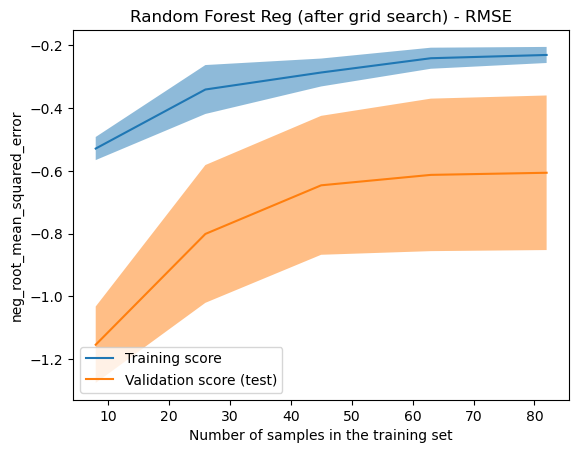

In [174]:
max_depth=best_max_depth
n_estimators = best_n_estimators

forest_reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
forest_reg.fit(X_train_norm, y_train)
forest_reg.predict(X_test_norm)

plot_learning_curve(forest_reg,  "Random Forest Reg (after grid search) - RMSE", X_train_norm, y_train, scoring="neg_root_mean_squared_error")

## SVM

Use the SVM regressor to estimate the death rate. See if you can get a better model than with the Random forest regressor.

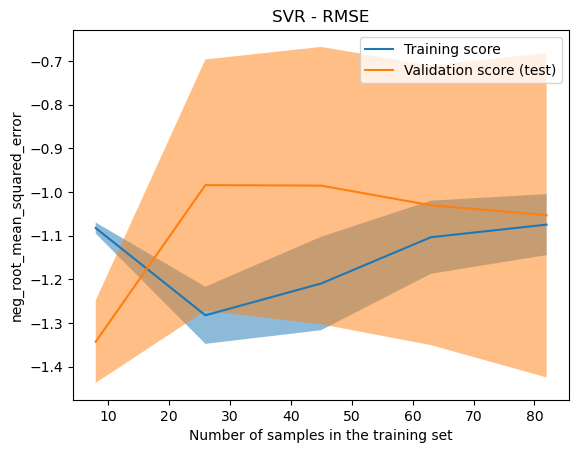

In [175]:
from sklearn.svm import SVR

kernel = 'rbf'
gamma = 'scale'
C = 1

svr = SVR(kernel=kernel, gamma=gamma, C=C)
svr.fit(X_train_norm, y_train)
svr.predict(X_test_norm)

plot_learning_curve(svr,  "SVR - RMSE", X_train_norm, y_train, scoring="neg_root_mean_squared_error")

In [136]:
from sklearn.model_selection import GridSearchCV

param_grid ={
    'kernel' : ['rbf','linear'],
    'gamma' : np.logspace(-10,10,100),
    'C':np.linspace(0.001,10000,100)
    }



svr = SVR()

svr_gs = GridSearchCV(svr, param_grid=param_grid, n_jobs=-1, cv=5, scoring="neg_root_mean_squared_error")
svr_gs.fit(X_train_norm, y_train)




GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.01011091e+02, 2.02021182e+02, 3.03031273e+02,
       4.04041364e+02, 5.05051455e+02, 6.06061545e+02, 7.07071636e+02,
       8.08081727e+02, 9.09091818e+02, 1.01010191e+03, 1.11111200e+03,
       1.21212209e+03, 1.31313218e+03, 1.41414227e+03, 1.51515236e+03,
       1.61616245e+03, 1.71717255e+03, 1.81818264e+0...
       1.45082878e+06, 2.31012970e+06, 3.67837977e+06, 5.85702082e+06,
       9.32603347e+06, 1.48496826e+07, 2.36448941e+07, 3.76493581e+07,
       5.99484250e+07, 9.54548457e+07, 1.51991108e+08, 2.42012826e+08,
       3.85352859e+08, 6.13590727e+08, 9.77009957e+08, 1.55567614e+09,
       2.47707636e+09, 3.94420606e+09, 6.28029144e+09, 1.00000000e+10]),
                         'kernel': ['rbf', 'linear']},
             scoring='neg_root_mean_squared_error')

In [176]:
svr_gs.best_estimator_

SVR(C=0.001, gamma=9.999999999999999e-11)

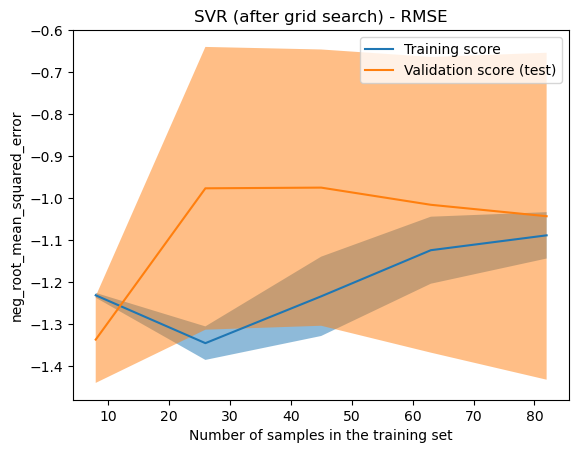

In [177]:
best_kernel = svr_gs.best_params_['kernel']
best_gamma = svr_gs.best_params_['gamma']
best_C = svr_gs.best_params_['C']

kernel = best_kernel
gamma = best_gamma
C = best_C

svr = SVR(kernel=kernel, gamma=gamma, C=C)
svr.fit(X_train_norm, y_train)
svr.predict(X_test_norm)

plot_learning_curve(svr,  "SVR (after grid search) - RMSE", X_train_norm, y_train, scoring="neg_root_mean_squared_error")

## Linear regression

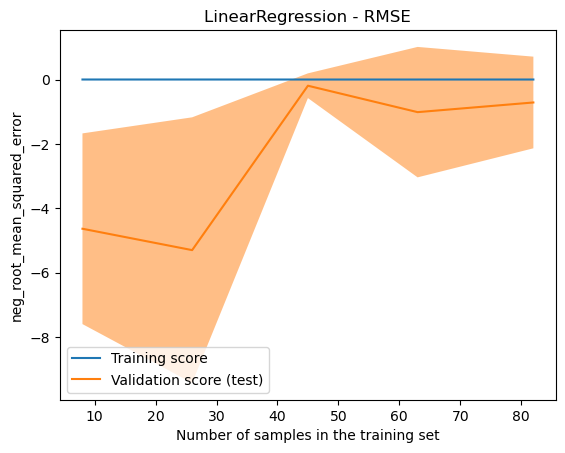

In [178]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_norm, y_train)
lin_reg.predict(X_test_norm)

plot_learning_curve(lin_reg,  "LinearRegression - RMSE", X_train_norm, y_train, scoring="neg_root_mean_squared_error")

# Dimensionality reduction

Let's take a look at the whole dataset and see if there are any clusters.

In order to do these perform and plot a PCA of 2 components.

Dimensionality reduction is a way to reduce the number of features in your dataset without having to lose much information and keep the model’s performance. Check out the Random Forest based method and PCA for dimensionality reduction in the following ressource:

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

## Random Forest feature selection

In [179]:
X_train

,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Miscellaneous,...,Confirmed,Recovered,Active,Population,Undernourished_0-10,Undernourished_11-20,Undernourished_21-30,Undernourished_31-40,Undernourished_41-50,Undernourished_51-60
103,0.0,15.4227,3.5807,0.0,7.1539,1.1517,1.2329,0.7014,6.9989,0.0074,...,1.114892,0.998734,0.097636,35952000.0,1.0,0.0,0.0,0.0,0.0,0.0
146,0.0,28.1054,6.2293,0.0,1.1241,0.9300,0.4048,0.3379,12.0906,0.0000,...,4.453984,3.570767,0.811941,8634000.0,1.0,0.0,0.0,0.0,0.0,0.0
18,0.0,24.6478,2.4453,0.0,3.6588,0.8354,0.3049,0.5976,9.6957,0.0915,...,3.092380,2.026394,0.962633,3281000.0,1.0,0.0,0.0,0.0,0.0,0.0
159,0.0,25.8633,4.2615,0.0,1.4678,1.0778,0.5176,0.4219,12.5789,0.0780,...,2.791642,0.006027,2.689576,67160000.0,1.0,0.0,0.0,0.0,0.0,0.0
12,0.0,25.8451,3.9733,0.0,2.1187,1.2130,1.8060,0.4636,13.1382,0.3235,...,0.103136,0.094774,0.005923,287000.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.0,12.2622,1.8696,0.0,3.7391,0.5224,0.3189,0.1980,5.8122,0.0385,...,2.457880,2.084971,0.341006,10679000.0,0.0,1.0,0.0,0.0,0.0,0.0
116,0.0,23.6146,2.3712,0.0,3.7744,1.4422,0.9290,0.7926,9.0171,0.0325,...,2.684150,2.509803,0.143115,4713000.0,1.0,0.0,0.0,0.0,0.0,0.0
16,0.0,6.1742,0.4816,0.0,4.6952,0.2064,0.8599,0.1978,3.2849,0.0258,...,0.025309,0.024343,0.000606,12209000.0,0.0,1.0,0.0,0.0,0.0,0.0
100,0.0,23.7741,3.2525,0.0,6.4604,2.2807,0.4661,0.5305,13.2133,0.0050,...,0.982827,0.725988,0.167399,127792000.0,1.0,0.0,0.0,0.0,0.0,0.0


In [182]:
y_train

103    0.600028
146    2.309037
18     3.348166
159    3.111247
12     0.079014
         ...   
77     1.033539
116    1.011803
16     0.011675
100    2.897480
112    0.010982
Name: Deaths, Length: 103, dtype: float64

In [183]:
from sklearn.inspection import permutation_importance

# X_train_norm
# forest_reg
feature_names = X_train.columns.values

forest_reg_importance = permutation_importance(forest_reg, X_train_norm, y_train, n_repeats=10, random_state=0, n_jobs=-1)

importance_mean =forest_reg_importance.importances_mean

importance_std = forest_reg_importance.importances_std


# importances = forest_clf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest_clf.estimators_], axis=0)

# forest_importances = pd.Series(importances, index=feature_names)




Plot the feature importance graph.

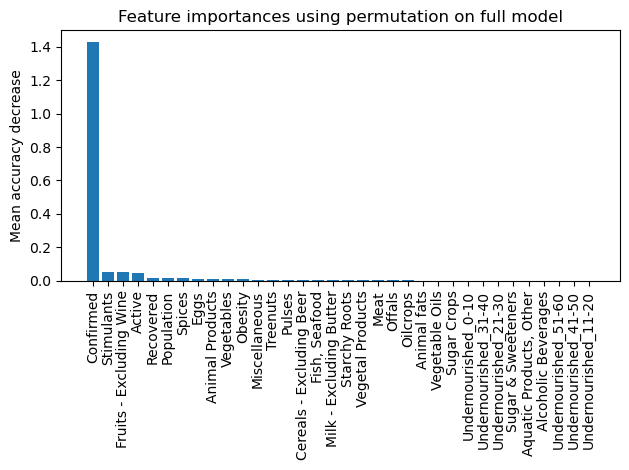

In [191]:
df = pd.DataFrame({
    "feature" : feature_names,
    "mean_importance" : importance_mean
}).sort_values(by='mean_importance', ascending=False)
fig, ax = plt.subplots()
plt.bar(x=df["feature"], height=df['mean_importance'])
# ax.set_xlabel(rot)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


Comment the graph.

## PCA dimensionality reduction

PCA is a technique which helps us in extracting a new set of variables from an existing large set of variables. Apply clustering methods on this new set of variables. Are the clusters obtained different than the clusters obtained on the "Obesity" vs "Deaths"?

Apply the Elbow method to determne the right number of clusters.

Use diverse methods to cluster the countries.

Pour plot PCA : 
https://plotly.com/python/pca-visualization/


In [206]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN


number_cluster = 5
kmeans = KMeans(n_clusters=number_cluster, random_state=42, n_init=10)
kmeans.fit(fat_quantity_norm)

meanshift = MeanShift()
meanshift.fit(fat_quantity_norm)

dbscan = DBSCAN()
dbscan.fit(fat_quantity_norm)

pca = PCA()
pca.fit(fat_quantity_norm)

df_pca = pd.DataFrame({
    "PC1" : pca.transform(fat_quantity_norm)[:, 0],
    "PC2" : pca.transform(fat_quantity_norm)[:, 1],
    "PC3" : pca.transform(fat_quantity_norm)[:, 2],
    "predicted_cluster_kmeans_n5" : kmeans.predict(fat_quantity_norm).astype(str),
    "predicted_cluster_meanshift" : meanshift.predict(fat_quantity_norm).astype(str),
    'predicted_cluster_dbscan' : dbscan.fit_predict(fat_quantity_norm).astype(str)
    })




def plot_eigen_values_pca(pca_after_fit):
    PC_names = np.arange(pca_after_fit.n_components_) + 1
    PC_explained_var = pca_after_fit.explained_variance_ratio_*100
    # PC_explained_var = pca_after_fit.explained_variance_
    # plt.plot(PC_names, 
    #      PC_explained_var, 
    #      'ro-')
    plt.bar(x=PC_names, height=PC_explained_var)
    plt.title('Scree Plot')
    plt.xlabel('Principal Components')
    plt.ylabel('Proportion of Variance Explained (%)')
    plt.show()





#données des individus sur l'ACP : 
#pca.transform(dataset)


# px.scatter(df_pca, 
#            x='PC1',
#            y='PC2', 
#            color="predicted_cluster_kmeans_n5",
#            width=600,
#            height=500)

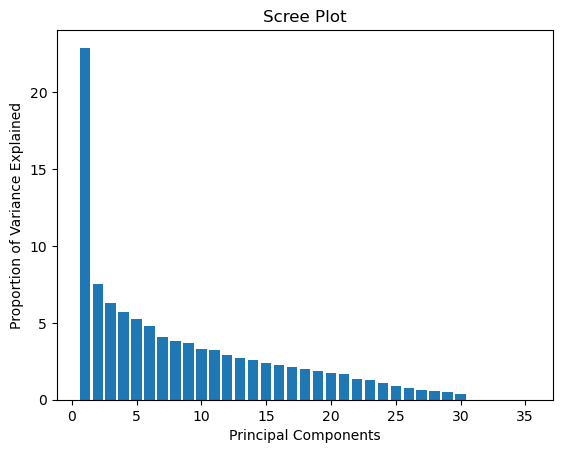

In [207]:
plot_eigen_values_pca(pca)

In [200]:
pca.explained_variance_

array([8.06127745e+00, 2.64667326e+00, 2.21788448e+00, 2.00280823e+00,
       1.84529476e+00, 1.68039917e+00, 1.42782053e+00, 1.33908173e+00,
       1.29311948e+00, 1.15394106e+00, 1.13148597e+00, 1.01281197e+00,
       9.57758205e-01, 9.10596862e-01, 8.45087698e-01, 7.91171579e-01,
       7.40765010e-01, 7.03129418e-01, 6.68155423e-01, 6.08171133e-01,
       5.79265314e-01, 4.78768096e-01, 4.41367122e-01, 3.77891880e-01,
       3.07266734e-01, 2.65060026e-01, 2.33626152e-01, 1.96478625e-01,
       1.70027073e-01, 1.37800234e-01, 3.77295961e-03, 3.83856322e-07,
       1.67846789e-07, 5.16902149e-11, 5.35932658e-32])

In [ ]:
def plot_var_pca(coeff, labels, dimension1 = 0, dimension2 = 1) :
    n=coeff.shape[0]
    for i in range(n):
        plt.arrow(0, 0, coeff[i,dimension1], coeff[i,dimension2], color = 'black', alpha = 0.25)
        if labels is None:
            plt.text(x=coeff[i,dimension1]* 1.15, y=coeff[i,dimension2] * 1.15, s="Var"+str(i+1), color = 'black', ha = 'center', va = 'center', fontsize=8)
        else:
            plt.text(x=coeff[i,dimension1]* 1.15, y=coeff[i,dimension2] * 1.15, s=labels[i], color = 'black', ha = 'center', va = 'center', fontsize=8)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel(f"PC{dimension1+1}")
    plt.ylabel(f"PC{dimension2+1}")
    plt.show()
#données des variables de l'ACP : 
#np.transpose(pca.components_[0:2, :])

In [ ]:
def biplot_pca(score, coeff, labels=None, cluster_color ="grey"):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    # scalex = 1.0/(xs.max() - xs.min())
    # scaley = 1.0/(ys.max() - ys.min())
    # plt.scatter(xs * scalex,ys * scaley, c= cluster_color, s=3, cmap='cool')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'black', alpha = 0.25)
        if labels is None:
            plt.text(x=coeff[i,0]* 1.15, y=coeff[i,1] * 1.15, s="Var"+str(i+1), color = 'black', ha = 'center', va = 'center', fontsize=8)
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center', fontsize=8)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

x_new = pca.fit_transform(fat_quantity_norm)
cluster = kmeans.predict(fat_quantity_norm).astype(int)
biplot_pca(x_new[:,0:2], np.transpose(pca.components_[0:2, :]), cluster_color=cluster)